<a href="https://colab.research.google.com/github/drtechniko/movies_i_like/blob/main/MovieBlockbusters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Welcome to the AI I made to select movies for me!**

First I need to load the data from my spreadsheet. I labeled some movies with "I like" and "I don't like" so that I can teach the AI my preferences.

In [70]:
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
import numpy as np

# Define function to load data from Google Sheet
def load_data_from_sheet():
  creds, _ = default()
  gc = gspread.authorize(creds)
  worksheet = gc.open('movies_i_like').worksheet('training')

  # get_all_values gives a list of rows.
  data = worksheet.get_all_values()
  #print(data)

  # Extract data assuming features follow the movie title and
  # the target labels are in the final column.
  features = np.array([[float(bool(x == 'TRUE')) for x in row[1:-1]] for row in data[1:]])  # Skip header row and Title column
  #target_labels = np.array([int(bool(row[-1])) for row in data[1:]])  # Extract labels from last column
  target_labels = np.array([int(bool(row[-1] == 'TRUE')) for row in data[1:]])  # Extract labels from last column
  return features, target_labels

# Load data from Google Sheet
X, y = load_data_from_sheet()
#print(X)
#print('do I like?')
#print(y)
# Save the number of features that we have so we can build our model later.
NUM_OF_FEATURES = len(X[0])

def load_movies_to_rate():
  creds, _ = default()
  gc = gspread.authorize(creds)
  worksheet = gc.open('movies_i_like').worksheet('inference')

  # get_all_values gives a list of rows.
  data = worksheet.get_all_values()
  # print(data)

  # Extract titles to build a map from title to features and expected_label
  moviesToRate = {}
  for row in data[1:]:
    title = row[0]
    features = np.array([float(bool(x == 'TRUE')) for x in row[1:-1]])
    expected_label = int(bool(row[-1] == 'TRUE'))
    moviesToRate[title] = (features, expected_label)

  return moviesToRate

moviesToRate  = load_movies_to_rate()
# print('moviesToRate')
# print(moviesToRate)

Now We Train Our Model and see how it improves its accuracy over time.


Test Accuracy: 1.0000


Text(0, 0.5, 'Loss')

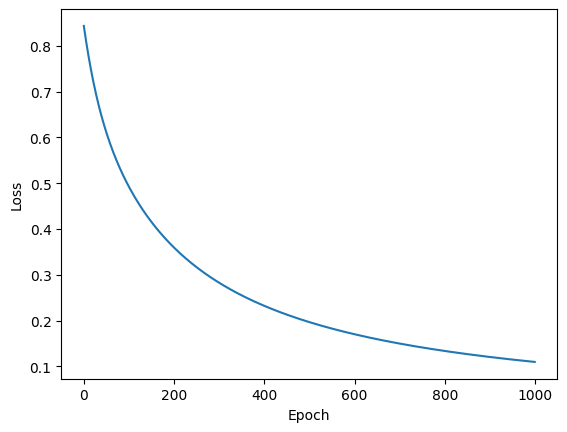

In [71]:
import torch
from torch import nn
from torch.optim import SGD
import numpy as np

from sklearn.model_selection import train_test_split

# Hyperparameters
learning_rate = 0.02
epochs = 1000

##### DANGEROUS CODE THAT GOOGLE'S CHATGPT/GEMINI generated for me!
##### It turned my likes into dislikes and vice versa!
# Encode target labels (0: dislike, 1: like)
# y = (y == 0).astype(int)  # Encode centers as 0 (dislike) and 1 (like)
#####

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=15)

# Convert data to tensors
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train.reshape(-1, 1)).float()
X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test.reshape(-1, 1)).float()

# Define model (linear layer with 1 output for binary classification)
class LogisticRegression(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, 1)  # Single output for binary classification

    def forward(self, x):
        # Apply sigmoid activation for probability output between 0 and 1
        return torch.sigmoid(self.linear(x))

# Create model and optimizer
model = LogisticRegression(NUM_OF_FEATURES)
optimizer = SGD(model.parameters(), lr=learning_rate)

# Define loss function (binary cross-entropy for classification)
loss_fn = nn.BCELoss()

# Train the model
loss_per_epoch = []
for epoch in range(epochs):
    # Forward pass
    y_pred = model(X_train_tensor)
    loss = loss_fn(y_pred, y_train_tensor)

    # Backward pass and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Save the loss for plotting
    loss_per_epoch.append(loss.item())
    # Print loss (optional)
    #if (epoch+1) % 100 == 0:
    #    print(f"Epoch: {epoch+1} - Loss: {loss.item():.4f}")

# Test the model on unseen data
with torch.no_grad():
    y_pred_test = model(X_test_tensor)
    # Apply threshold (e.g., 0.5) to convert probabilities to predicted classes
    predicted_classes = (y_pred_test > 0.5).float()

# Calculate accuracy (optional)
accuracy = (predicted_classes == y_test_tensor).sum().item() / len(y_test_tensor)
print(f"\nTest Accuracy: {accuracy:.4f}")

#print('model weights:')
#print(model.linear.weight)
#print('model biases:')
#print(model.linear.bias)

import matplotlib.pyplot as plt
# Plot loss function (using entire training data for visualization)
plt.plot(range(epochs), loss_per_epoch)
plt.xlabel("Epoch")
plt.ylabel("Loss")


Now we visualize the result of training the AI

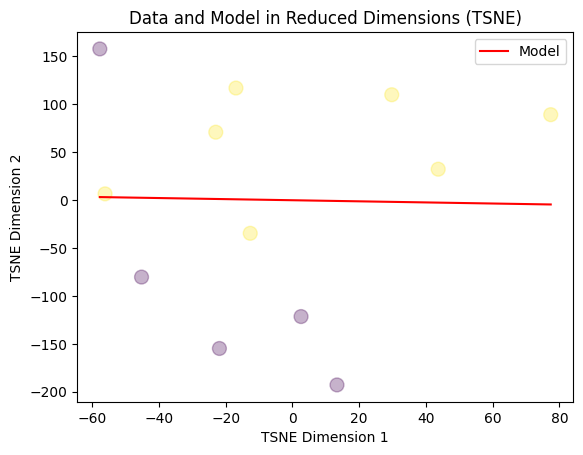

In [72]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Apply TSNE for dimensionality reduction (optional)
tsne = TSNE(n_components=2, perplexity = 5.0, random_state=5)
X_tsne = tsne.fit_transform(X) #n_samples = 12, n_features = 12

# Scatter plot data points colored by target value
area = [10**2] * len(y)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=area, c=y, alpha = 0.3, cmap="viridis")

# Plot the model line (y = weights * x + bias)
x1 = np.linspace(min(X_tsne[:, 0]), max(X_tsne[:, 0]), 100)

weight = np.mean(model.linear.weight[0].detach().numpy())
bias = model.linear.bias[0].detach().numpy()

y1 = weight * x1 + bias
plt.plot(x1, y1, color="red", label="Model")
plt.xlabel("TSNE Dimension 1")
plt.ylabel("TSNE Dimension 2")
plt.title("Data and Model in Reduced Dimensions (TSNE)")
plt.legend()
plt.show()

Now Let's see how well it will figure out whether I like or not another show that it has not seen before.

In [73]:
def say(iLike):
  if iLike:
    return 'Yes!\n'
  else:
    return 'Nope.\n'

def getAnswer(movie):
  score = model(torch.from_numpy(moviesToRate[movie][0]).float()).item()
  print(f"Likelihood: {100*score:.1f}%")
  return score > 0.5

model.eval()

print('Do I like Naruto?')
print(say(getAnswer('Naruto')))

print('Do I Like Star Wars?')
print(say(getAnswer('Star Wars')))

print('Do I Like High School Musical?')
print(say(getAnswer('High School Musical')))

print('Do I Like The Princess Diaries?')
print(say(getAnswer('The Princess Diaries')))

print('Do I Like Stranger Things?')
print(say(getAnswer('Stranger Things')))

Do I like Naruto?
Likelihood: 94.3%
Yes!

Do I Like Star Wars?
Likelihood: 92.9%
Yes!

Do I Like High School Musical?
Likelihood: 2.6%
Nope.

Do I Like The Princess Diaries?
Likelihood: 8.7%
Nope.

Do I Like Stranger Things?
Likelihood: 80.1%
Yes!

